# Table of Contents

* [Introduction: Problem Description](#problem_description)

* [Introduction: Data Description](#data_description)

* [Methodology](#methodology)

* [Results](#results)

* [Discussion & Conclusion](#conclusion)

## Problem Description <a name="problem_description"></a>


In this report, I would like to address the question of where to open a new food business (i.e. cafe, restaurant, etc.) in Cambridge, UK. The potential stakeholders are the people who are interested in opening a new food business in the Cambridge area. The general rationale behind this analysis is the following:

(1) An area with a lot of food businesses already implies that there is a lot of competition among the businesses.

(2) An area with a large number of population means that there is a large potential customer base.

(3) An area that is far away from town centre means that people are less likely to travel there.


We will aim to address this problem using information relevant to the above three considerations.

## Data Description <a name='data_description'></a>

The data that I will be using are obtained using the Foursquare API, which contains the location information of different food businesses in Cambridge, UK.

Below are my code for obtaining the data, and an initial exploratory analysis.

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/hankui/anaconda3

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2019.9.11          |           py37_0         147 KB  conda-forge
    conda-4.8.4                |   py37hc8dfbb8_2         3.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.7             |          1_cp37m          

In [1]:
# import necessary libraries
import folium # plotting library
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

In [3]:
# sensitive Foursquare log-in info 

In [10]:
import requests

request_parameters = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "v": VERSION,
    "section": "food",
    "near": "Cambridge, UK",
    "radius": 10000,
    "limit": 10000}

data = requests.get("https://api.foursquare.com/v2/venues/explore", params=request_parameters)

In [11]:
d = data.json()["response"]
d.keys()

dict_keys(['suggestedFilters', 'geocode', 'headerLocation', 'headerFullLocation', 'headerLocationGranularity', 'query', 'totalResults', 'suggestedBounds', 'groups'])

In [12]:
items = d["groups"][0]["items"]

df_raw = []
for item in items:
    venue = item["venue"]
    categories, uid, name, location = venue["categories"], venue["id"], venue["name"], venue["location"]
    assert len(categories) == 1
    shortname = categories[0]["shortName"]
    
    if not "address" in location:
        continue
    address = location['address']
    
    if not "postalCode" in location:
        continue
    postalcode = location["postalCode"]
    lat = location["lat"]
    lng = location["lng"]
    
    datarow = (uid, name, shortname, address, postalcode, lat, lng)
    df_raw.append(datarow)

df = pd.DataFrame(df_raw, columns=["uid", "name", "shortname", "address", "postalcode", "lat", "lng"])
print("found %i cafes" % len(df))
df.head()

found 68 cafes


,uid,name,shortname,address,postalcode,lat,lng
0,54a3f973498e5bb40a6ddd35,bread & meat,Sandwiches,4 Benet St,CB2 3QN,52.204011,0.118396
1,5184c967498e0b8ab6cae4ba,Aromi,Café,1 Bene’t Street,CB2 3QN,52.204278,0.118949
2,4bae262df964a520428a3be3,Cambridge Chop House,English,1 King's Parade,CB2 1SJ,52.203917,0.117654
3,4dc0055b81545e1cc7da8af0,Hot Numbers,Café,6 Dale's Brewery,CB1 2LJ,52.200038,0.138520
4,54db1685498ed6e364d96694,Espresso Library,Café,210 East Rd,CB1 1BG,52.203163,0.131713


In [13]:
d["geocode"]

{'what': '',
 'where': 'cambridge uk',
 'center': {'lat': 52.2, 'lng': 0.11667},
 'displayString': 'Cambridge, Cambridgeshire, United Kingdom',
 'cc': 'GB',
 'geometry': {'bounds': {'ne': {'lat': 52.23097999999993,
    'lng': 0.17491199999983564},
   'sw': {'lat': 52.17158499999988, 'lng': 0.09852149999989024}}},
 'slug': 'cambridge-united-kingdom',
 'longId': '72057594040581877'}

In [14]:
cambridge_centre = d["geocode"]["center"]

from folium import plugins

# create map of Cambridge using latitude and longitude values
cambridge_map = folium.Map(location = [cambridge_centre["lat"], cambridge_centre["lng"]], zoom_start = 12)

def add_markers(df):
    for (j, row) in df.iterrows():
        label = folium.Popup(row["name"], parse_html = True)
        folium.CircleMarker(
            [row["lat"], row["lng"]],
            radius = 6,
            popup = label,
            color = 'blue',
            fill = True,
            fill_color = '#3186cc',
            fill_opacity = 0.7,
            parse_html = False).add_to(cambridge_map)

add_markers(df)
hm_data = df[["lat", "lng"]].as_matrix().tolist()
cambridge_map.add_child(plugins.HeatMap(hm_data))

cambridge_map

/home/hankui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Methodology <a name="methodology"></a>

In this section, we first gather all the information we will use for our analysis, which includes: (1) the coordinate information for all the food businesses in Cambridge; (2) the population information in each postcode area; and (3) the number of food businesses in each postcode area.


To begin with, we will use K-means clustering to group all the businesses into a large number of clusters. We will then recommend one or a few of these clusters to the stakeholders by taking into account the above listed information. 

In [19]:
# check the number of unique type of businesses
np.unique(df.shortname)

array(['African', 'American', 'Asian', 'Breakfast', 'Burgers', 'Café',
       'Chinese', 'Deli / Bodega', 'Dumplings', 'English', 'Fast Food',
       'Fish & Chips', 'French', 'Gastropub', 'Indian', 'Italian',
       'Latin American', 'Portuguese', 'Restaurant', 'Sandwiches',
       'Seafood', 'Steakhouse', 'Sushi'], dtype=object)

In [23]:
np.unique([val[:3] for val in df.postalcode])

array(['CB1', 'CB2', 'CB3', 'CB4', 'CB5', 'Cb2'], dtype='<U3')

In [31]:
df['short_pc'] = [val[:3] for val in df.postalcode]

for ind, val in enumerate(df['short_pc']):
    if val == 'Cb2':
        df['short_pc'][ind] = 'CB2'

/home/hankui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [32]:
df.head()

,uid,name,shortname,address,postalcode,lat,lng,short_pc
0,54a3f973498e5bb40a6ddd35,bread & meat,Sandwiches,4 Benet St,CB2 3QN,52.204011,0.118396,CB2
1,5184c967498e0b8ab6cae4ba,Aromi,Café,1 Bene’t Street,CB2 3QN,52.204278,0.118949,CB2
2,4bae262df964a520428a3be3,Cambridge Chop House,English,1 King's Parade,CB2 1SJ,52.203917,0.117654,CB2
3,4dc0055b81545e1cc7da8af0,Hot Numbers,Café,6 Dale's Brewery,CB1 2LJ,52.200038,0.138520,CB1
4,54db1685498ed6e364d96694,Espresso Library,Café,210 East Rd,CB1 1BG,52.203163,0.131713,CB1


In [33]:
np.unique(df.short_pc)

array(['CB1', 'CB2', 'CB3', 'CB4', 'CB5'], dtype=object)

We bring in the population information by district, as a guide for the population density. This information can be found here: https://www.streetcheck.co.uk/postcode/alldistricts

In [34]:
population = [73484, 49176, 56045, 78319, 33457]

Also count the number of food businesses in this postal area.

In [40]:
num_business = df.groupby('short_pc').count().iloc[:,0]
num_business

short_pc
CB1    17
CB2    39
CB3     6
CB4     2
CB5     4
Name: uid, dtype: int64

Create 2 new columns in the data frame to store the 'population' information and the 'num_business' information.

In [73]:
for ind, val in enumerate(df.short_pc):
    
    if val == 'CB1':
        df['population'][ind] = population[0]
        df['num_business'][ind] = num_business[0]
    if val == 'CB2':
        df['population'][ind] = population[1]
        df['num_business'][ind] = num_business[1]
    if val == 'CB3':
        df['population'][ind] = population[2]
        df['num_business'][ind] = num_business[2]
    if val == 'CB4':
        df['population'][ind] = population[3]
        df['num_business'][ind] = num_business[3]
    if val == 'CB5':
        df['population'][ind] = population[4]
        df['num_business'][ind] = num_business[4]

df.head()

/home/hankui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/hankui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/hankui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/hankui/anaconda3/lib

,uid,name,shortname,address,postalcode,lat,lng,short_pc,population,num_business,labels
0,54a3f973498e5bb40a6ddd35,bread & meat,Sandwiches,4 Benet St,CB2 3QN,52.204011,0.118396,CB2,49176,39,1
1,5184c967498e0b8ab6cae4ba,Aromi,Café,1 Bene’t Street,CB2 3QN,52.204278,0.118949,CB2,49176,39,1
2,4bae262df964a520428a3be3,Cambridge Chop House,English,1 King's Parade,CB2 1SJ,52.203917,0.117654,CB2,49176,39,1
3,4dc0055b81545e1cc7da8af0,Hot Numbers,Café,6 Dale's Brewery,CB1 2LJ,52.200038,0.138520,CB1,73484,17,6
4,54db1685498ed6e364d96694,Espresso Library,Café,210 East Rd,CB1 1BG,52.203163,0.131713,CB1,73484,17,1


We define the following goals that we want to achieve:
    * A location that is as close to town centre as possible
    * A location that is in a fairly densely populated area
    * A location that is not in an area with too many food businesses already

In order to form potential location candidates, we first discretise the whole Cambridge area that we consider. As a second step, we will then calculate a suitability score for each candidate location and suggest a few most promising locations to the stakeholders.

1. Discretise the area through K-means clustering, with the location information of existing food businesses.

In [44]:
df_loc = df[['lat','lng']]
 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans.fit(df_loc)

KMeans(n_clusters=10)

In [49]:
labels = kmeans.predict(df_loc)

centroids = pd.DataFrame(kmeans.cluster_centers_)

In [74]:
df['labels'] = labels
df.head()

,uid,name,shortname,address,postalcode,lat,lng,short_pc,population,num_business,labels
0,54a3f973498e5bb40a6ddd35,bread & meat,Sandwiches,4 Benet St,CB2 3QN,52.204011,0.118396,CB2,49176,39,1
1,5184c967498e0b8ab6cae4ba,Aromi,Café,1 Bene’t Street,CB2 3QN,52.204278,0.118949,CB2,49176,39,1
2,4bae262df964a520428a3be3,Cambridge Chop House,English,1 King's Parade,CB2 1SJ,52.203917,0.117654,CB2,49176,39,1
3,4dc0055b81545e1cc7da8af0,Hot Numbers,Café,6 Dale's Brewery,CB1 2LJ,52.200038,0.138520,CB1,73484,17,6
4,54db1685498ed6e364d96694,Espresso Library,Café,210 East Rd,CB1 1BG,52.203163,0.131713,CB1,73484,17,1


Calculate the Euclidean distance between each business to Cambridge town centre.

In [84]:
centre_coord = np.array((cambridge_centre['lat'], cambridge_centre['lng']))

dists = []

for i in range(len(df)):
    coord = np.array((df['lat'][i], df['lng'][i]))
    dists.append(np.linalg.norm(coord - centre_coord))

df['dists'] = dists
df.head()

,uid,name,shortname,address,postalcode,lat,lng,short_pc,population,num_business,labels,dists
0,54a3f973498e5bb40a6ddd35,bread & meat,Sandwiches,4 Benet St,CB2 3QN,52.204011,0.118396,CB2,49176,39,1,0.004367
1,5184c967498e0b8ab6cae4ba,Aromi,Café,1 Bene’t Street,CB2 3QN,52.204278,0.118949,CB2,49176,39,1,0.004848
2,4bae262df964a520428a3be3,Cambridge Chop House,English,1 King's Parade,CB2 1SJ,52.203917,0.117654,CB2,49176,39,1,0.004039
3,4dc0055b81545e1cc7da8af0,Hot Numbers,Café,6 Dale's Brewery,CB1 2LJ,52.200038,0.138520,CB1,73484,17,6,0.021850
4,54db1685498ed6e364d96694,Espresso Library,Café,210 East Rd,CB1 1BG,52.203163,0.131713,CB1,73484,17,1,0.015372


Next, we visualise the map again with blue markers indicating the individual businesses and pink markers indicating the cluster centres.

In [55]:
cambridge_centre = d["geocode"]["center"]

from folium import plugins

# create map of Cambridge using latitude and longitude values
cambridge_map = folium.Map(location = [cambridge_centre["lat"], cambridge_centre["lng"]], zoom_start = 12)

def add_markers(df):
    for (j, row) in df.iterrows():
        label = folium.Popup(row["name"], parse_html = True)
        folium.CircleMarker(
            [row["lat"], row["lng"]],
            radius = 6,
            popup = label,
            color = 'blue',
            fill = True,
            fill_color = '#3186cc',
            fill_opacity = 0.7,
            parse_html = False).add_to(cambridge_map)

def add_centroids(df):
    for (j, row) in centroids.iterrows():
        #label = folium.Popup(row["name"], parse_html = True)
        folium.CircleMarker(
            [row[0], row[1]],
            radius = 10,
            #popup = label,
            color = 'pink',
            fill = True,
            fill_color = '#FFC0CB',
            fill_opacity = 0.7,
            parse_html = False).add_to(cambridge_map)
        
add_markers(df)
add_centroids(df)
#hm_data = df[["lat", "lng"]].as_matrix().tolist()
hm_data = centroids.as_matrix().tolist()
cambridge_map.add_child(plugins.HeatMap(hm_data))

cambridge_map

/home/hankui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


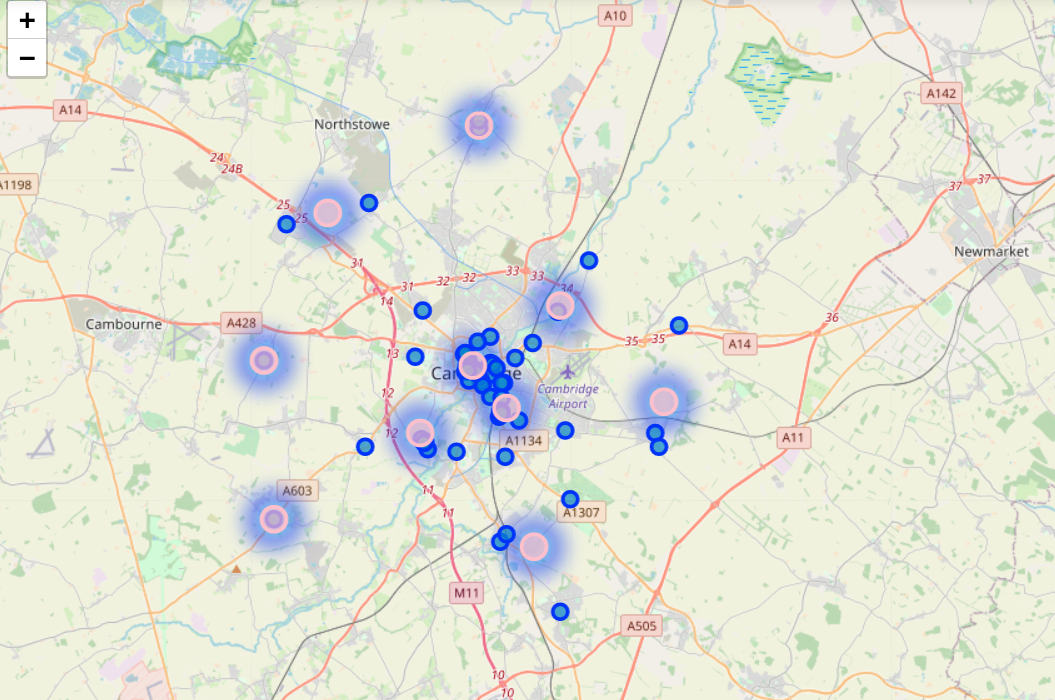

In [56]:
# A snapshot of the map
from IPython.display import display, Image
display(Image(filename='Cambridge_map_with_centres.png'))

In [96]:
df_candidates = df.groupby('labels').mean()
df_candidates

,lat,lng,population,num_business,dists
labels,,,,,
0,52.144887,0.155477,49176.000000,39.000000,0.069271
1,52.206094,0.121683,55071.724138,30.310345,0.010021
2,52.207620,0.006908,49176.000000,39.000000,0.110026
3,52.193697,0.226838,49176.000000,39.000000,0.111839
4,52.286814,0.124988,49176.000000,39.000000,0.087212
5,52.183351,0.092354,54082.428571,15.428571,0.032536
6,52.191593,0.140142,66424.562500,20.312500,0.025789
7,52.257065,0.041705,49176.000000,39.000000,0.095692
8,52.226269,0.169436,38696.666667,15.666667,0.059133


## Results <a name="results"></a>

Next, we rank each of the 10 centroids from 1 to 10, with a higher score being more favourable. Therefore, a large population would get a high score. However, the higher 'num_business' and 'dists' are, the lower the score should be.

In [108]:
#np.array(df_candidates['population']).argsort()

li = df_candidates['population'].tolist()
score1 = [(v-min(li))/(max(li)-min(li)) for v in li]

li = df_candidates['num_business'].tolist()
score2 = [(v-min(li))/(max(li)-min(li)) for v in li]

li = df_candidates['dists'].tolist()
score3 = [(v-min(li))/(max(li)-min(li)) for v in li]

[x-y-z for x,y,z in zip(score1, score2, score3)]

[-1.1930295140235474,
 -0.040785390678790945,
 -1.585769919647622,
 -1.6032361061870242,
 -1.3659203156548716,
 0.33791897487600053,
 0.6408535465889988,
 -1.4476390477638912,
 -0.48336787552383315,
 -1.6220653238052232]

We can see that there are only two locations with positive scores: the 6th and 7th centroid. Let's visualise these two areas on the map.

In [111]:
recommends = centroids.iloc[5:7,:]
recommends

,0,1
5,52.183351,0.092354
6,52.191593,0.140142


In [112]:
# create map of Cambridge using latitude and longitude values
cambridge_map = folium.Map(location = [cambridge_centre["lat"], cambridge_centre["lng"]], zoom_start = 12)

def add_markers(df):
    for (j, row) in df.iterrows():
        label = folium.Popup(row["name"], parse_html = True)
        folium.CircleMarker(
            [row["lat"], row["lng"]],
            radius = 6,
            popup = label,
            color = 'blue',
            fill = True,
            fill_color = '#3186cc',
            fill_opacity = 0.7,
            parse_html = False).add_to(cambridge_map)

def add_recommends(df):
    for (j, row) in recommends.iterrows():
        #label = folium.Popup(row["name"], parse_html = True)
        folium.CircleMarker(
            [row[0], row[1]],
            radius = 10,
            #popup = label,
            color = 'pink',
            fill = True,
            fill_color = '#FFC0CB',
            fill_opacity = 0.7,
            parse_html = False).add_to(cambridge_map)
        
add_markers(df)
add_recommends(df)
#hm_data = df[["lat", "lng"]].as_matrix().tolist()
hm_data = centroids.as_matrix().tolist()
cambridge_map.add_child(plugins.HeatMap(hm_data))

cambridge_map

/home/hankui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


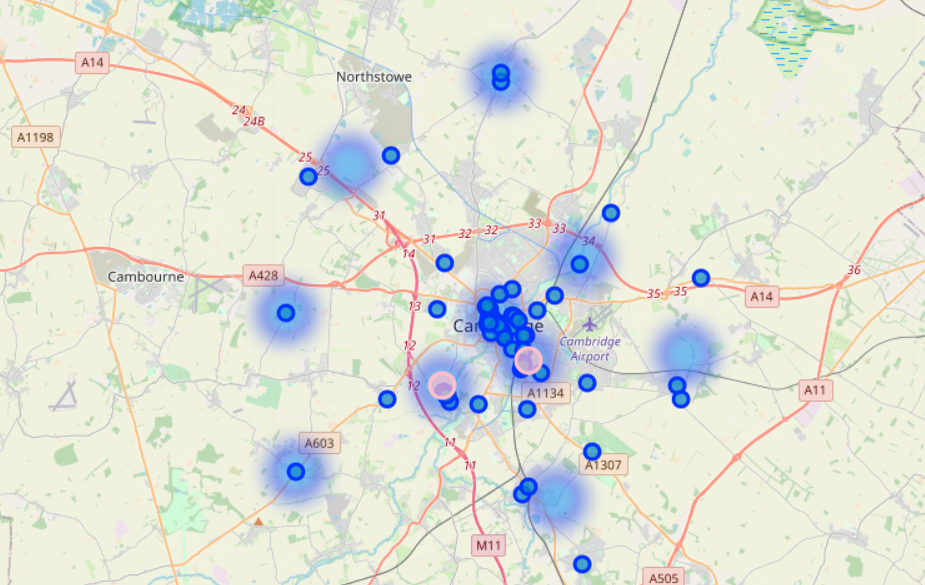

In [113]:
# A snapshot of the recommended locations
from IPython.display import display, Image
display(Image(filename='recommended_locations.png'))

## Discussion & Conclusion <a name="conclusion"></a>

As we can see from the map, one of the recommended locations is in a fairly central area. However, it lies on the boundary of the dense area. We could interpret this recommendation as picking a less competitive location (in terms of business) within a popular area. The other recommended location is also fairly close to town centre, and lies in a moderately popular area in terms of the number of business. Overall, our recommendation combines the population density of the area (positive), the number of businesses in the area (negative), and the distance between an area to the town centre (negative).